In [1]:
import os
import random
import math
import itertools
import sys
from copy import deepcopy

import einops
import pandas as pd
import numpy as np
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from abc import ABC, abstractmethod
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


device = t.device("cuda" if t.cuda.is_available() else "cpu")


In [2]:
import numpy as np

def relu(x):
    return np.maximum(0, x)

# Step 1: Input data
X = np.array([
    [1, 2, 3, 2],
    [1, 1, 2, 4],
    [2, 2, 4, 1],
    [1, 0, 1, 1]
])  # Shape: (4, 4)
print("Input X:")
print(X)

# Step 2: Encoder layer 1 (W1: 3x4)
W1 = np.array([
    [1, 0, 1, -1],
    [0, 1, 0, 0],
    [-1, 0, -1, 0]
])  # Shape: (3, 4)

encoder_layer1 = relu(X @ W1.T)  # (4,4) @ (4,3) → (4,3)
print("\nEncoder Layer 1 Output (ReLU):")
print(encoder_layer1)

# Step 3: Encoder layer 2 (W2: 3x2)
W2 = np.array([
    [1, 0],
    [-1, 1],
    [1, 0]
])  # Shape: (3, 2)

encoded = relu(encoder_layer1 @ W2)  # (4,3) @ (3,2) → (4,2)
print("\nEncoded Output (Bottleneck):")
print(encoded)

# Step 4: Decoder layer 1 (W3: 2x3)
W3 = np.array([
    [1, 0, 1],
    [0, 1, 1]
])  # Shape: (2, 3)

decoder_layer1 = relu(encoded @ W3)  # (4,2) @ (2,3) → (4,3)
print("\nDecoder Layer 1 Output (ReLU):")
print(decoder_layer1)

# Step 5: Final decoder layer (W4: 3x4)
W4 = np.array([
    [1, 0, -1, 1],
    [-1, 0, 1, 0],
    [0, 1, 0, -1]
])  # Shape: (3, 4)

decoded = relu(decoder_layer1 @ W4)  # (4,3) @ (3,4) → (4,4)
print("\nDecoded Output (ReLU):")
print(decoded)



Input X:
[[1 2 3 2]
 [1 1 2 4]
 [2 2 4 1]
 [1 0 1 1]]

Encoder Layer 1 Output (ReLU):
[[2 2 0]
 [0 1 0]
 [5 2 0]
 [1 0 0]]

Encoded Output (Bottleneck):
[[0 2]
 [0 1]
 [3 2]
 [1 0]]

Decoder Layer 1 Output (ReLU):
[[0 2 2]
 [0 1 1]
 [3 2 5]
 [1 0 1]]

Decoded Output (ReLU):
[[0 2 2 0]
 [0 1 1 0]
 [1 5 0 0]
 [1 1 0 0]]


### Purpose of this notebook

Let us try to build a sparse autoencoder (SAE) that takes in some dummy variables in line with the representation that will be needed down the line!

The goal is to accomplish the following:

1. Construct an architecture like the one in the [Anthropic paper](https://transformer-circuits.pub/2023/monosemantic-features)
2. Define the appropriate losses of interest e.g: 
    - ReLU (April '24 update of Anthropic version, pre Scaling paper) [seen here](https://transformer-circuits.pub/2024/april-update/index.html#training-saes), while the newest Jan '25 update is much more in depth and complex with Gated etc. (see [here](https://transformer-circuits.pub/2025/january-update/index.html))
    - Gated SAE's
    - JumpReLU
    - TopK/BatchTopK/Matryoshka BatckTopK? (?)
3. Implement the training loop


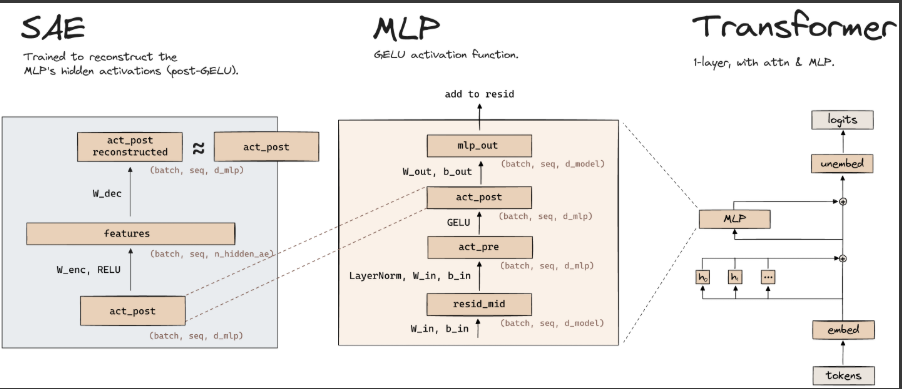

In [3]:
from dataclasses import dataclass
@dataclass
class SAEConfig:
    """Configuration for the Sparse Autoencoder (SAE) model.
    Args:
        d_in (int): Input dimension.
        d_latent (int): Dimension of the sparse autoencoder.
        sparsity_coeff (float): Coefficient for the sparsity penalty.

        ste_epsilon (float): Epsilon for straight-through estimator.
    """
    d_in: int
    d_latent: int
    sparsity_coeff: float = 0.11
    

In [4]:
class SparseAutoEncoder(nn.Module):
    """
    A one-layer autoencoder.
    """

    def __init__(self, cfg: SAEConfig,  resample_interval: int = 25_000) -> None:
        """
        act_dim : No. neuronal activation dimensions (from LLM)
        latent_dim : No. hidden layer dimensions (aka. the dictionary size)
        lmbda : sparsity parameter
        resample_interval : No. train steps for resampling dead neurons
        """
        super(SparseAutoEncoder, self).__init__()
        # TODO: assert cfg.d_in == model.cfg.d_hidden, "Model's hidden dim doesn't match SAE input dim."
        self.cfg = cfg
        # TODO: default PyTorch Kaiming uniform initalization
        # Decoder needs columns of unit norm
        # There's a bias attached to each one
        # x_bar = x - b_d
        
        # so they have a pre-bias from decoder -->
        # "We constrain the pre-encoder bias to equal the negative of the post-decoder bias and initialize it to the geometric median of the dataset. "
        # f = ReLU(W_e @ x_bar + b_e)
        # x_hat = W_d @ f + b_d
        # L = 1 / |X|    * sum_{x \in X} ||x - x_hat||^2 + lambda ||f||_1
        # W_e : encoder weight matrix (latent_dim x act_dim)
        # W_d : decoder weight matrix (act_dim x latent_dim)
        # b_e : encoder bias (latent_dim)
        # b_d : decoder bias (act_dim)
        # f : latent features (latent_dim)
        # x_hat : reconstructed activations (act_dim)
        self.relu = nn.ReLU()     
        
        # Init bias as zero
        self.b_enc = nn.Parameter(t.zeros(self.cfg.d_latent))
        self.b_dec = nn.Parameter(t.zeros(self.cfg.d_in)) # b_d
        self.encoder = nn.Linear(self.cfg.d_in, self.cfg.d_latent, bias = False) # nn.Linear uses kaiming uniform
        self.decoder = nn.Linear(self.cfg.d_latent, self.cfg.d_in, bias = False) 
        self.W_dec_normalized() # Normalize the decoder's weight vectors (columns) to have unit norm along the feature (input) dimension.


    def encode(self, x):
        x_bar = x - self.b_dec # x_bar = x - b_d
        return self.relu( self.encoder(x_bar) + self.b_enc )  # f = ReLU(W_e @ x_bar + b_e)

    def decode(self, f):
        return self.decoder(f) + self.b_dec # x_hat = W_d_normalized @ f + b_d

    def forward(self, x):
        """
        Forward pass of an autoencoder.
        x : activations to be autoencoded
        output_features : if True, return the encoded features as well as the decoded x
        """
        latents = self.encode(x) # f = ReLU(W_e @ x_bar + b_e)
        reconstructed = self.decode(latents)
        loss = self.calculate_sae_loss(x, latents, reconstructed)
        if self.training:
            return {
                'loss': loss, 
                'latents': latents, 
                'reconst_acts': reconstructed}
        else:
            return {
                'loss': loss,
                'latents': latents,
                'reconst_acts': reconstructed,
                'mse_loss': self.mse_loss(reconstructed, x),
                'l1_loss': self.l1_loss(latents)
            }
            


    @t.no_grad()
    def W_dec_normalized(self):
        """
        Normalize the decoder's weight vectors to have unit norm along the feature dimension.
        This is important for the decoder to work properly. 
        """
        self.decoder.weight.data = F.normalize(self.decoder.weight.data, dim=0)
    
    def remove_parallel_component_of_decoder_grad(self):
        """
        Remove the component of the gradient parallel to the decoder's weight vectors.
        From Towards Monosemanticity: 
        
        'Recall that we constrain our dictionary vectors to have unit norm. 
        Our first naive implementation simply reset all vectors to unit norm after each gradient step. 
        This means any gradient updates modifying the length of our vector are removed, 
        creating a discrepancy between the gradient used by the Adam optimizer and the true gradient.
        We find that instead removing any gradient information parallel to our dictionary vectors before 
        applying the gradient step results in a small but real reduction in total loss.'
        """
        unit_weights = F.normalize(self.decoder.weight, dim=0) # \hat{b}
        proj = (self.decoder.weight.grad * unit_weights).sum(dim=0) * unit_weights 
        self.decoder.weight.grad = self.decoder.weight.grad - proj


    def calculate_sae_loss(self, x, encoded, reconstructed):
        mse_loss = self.mse_loss(reconstructed, x)
        l1_loss = self.l1_loss(encoded)
        return mse_loss + self.cfg.sparsity_coeff * l1_loss

    def mse_loss(self, reconstructed, original):
        return F.mse_loss(reconstructed, original)

    def l1_loss(self, encoded):
        return F.l1_loss(encoded, t.zeros_like(encoded), reduction='sum') / encoded.shape[0]

Another note - the use of $b_{dec}$ here might seem weird, since we're subtracting it at the start then adding it back at the end. The way we're treating this term is as a **centralizing term for the hidden states**. It subtracts some learned mean vector from them so that $W_{enc}$ can act on centralized vectors, and then this term gets added back to the reconstructed hidden states at the end of the model.

------------

The toy model studied in [Anthropic's paper](https://transformer-circuits.pub/2022/toy_model/index.html) has some keen examples for guiding our intuition.

The input $x$ represents our five features (they're uniformly sampled between 0 and 1).

The justification for using $W^T W$ is as follows: we can think of $W$ (which is a matrix of shape `(2, 5)`) as a grid of "overlap values" between the features and bottleneck dimensions. The values of the 5x5 matrix $W^T W$ are the dot products between the 2D representations of each pair of features. To make this intuition clearer, imagine each of the columns of $W$ were unit vectors, then $W^T W$ would be a matrix of cosine similarities between the features (with diagonal elements equal to 1, because the similarity of a feature with itself is 1). To see this for yourself:


In [5]:
t.manual_seed(2)

W = t.randn(2, 5)
W_normed = W / W.norm(dim=0, keepdim=True)

import plotly.express as px

px.imshow(W_normed.T @ W_normed, title="Cosine similarities of each pair of 2D feature embeddings", width=600, color_continuous_scale='RdBu')

As mentioned, you can view $W$ as being a set of five 2D vectors, one for each of our five features. 

The heatmap shows us the cosine similarities between each pair of these vectors, and the second plot shows us these five vectors in 2D space.

In [6]:
def plot_features_in_2d(W):
    """
    W is a tensor of shape (2, num_features)
    Plots each column vector as a point in 2D
    """
    # Plot each column vector
    plt.figure(figsize=(3, 3))
    for i in range(W.shape[1]):
        plt.plot([0, W[0, i].item()], [0, W[1, i].item()], 'k-')  # Line from origin
        plt.plot(W[0, i].item(), W[1, i].item(), 'ko')           # Dot at the end
    
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(False)
    plt.show()

We can see two pairs of vectors (the 1st & 2nd, and the 0th & 4th) have very high cosine similarity.

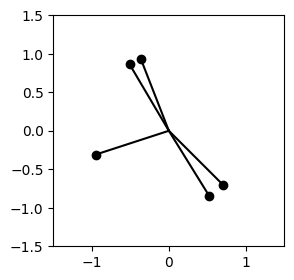

In [7]:
# Call the plotting function
plot_features_in_2d(W_normed)

Some dummy data to see if it learns something... Taken from [here](https://medium.com/data-science/sparse-autoencoder-from-superposition-to-interpretable-features-4764bb37927d)

In [8]:
data = t.tensor([
    # Cat categories
    [0.8, 0.3, 0.1, 0.05],  # "cat"
    [0.82, 0.32, 0.12, 0.06],  # "happy cat" (similar to "cat")
    # Dog categories
    [0.7, 0.2, 0.05, 0.2],  # "dog"
    [0.75, 0.3, 0.1, 0.25],  # "loyal dog" (similar to "dog")
    
    # "Not animal" categories
    [0.05, 0.9, 0.4, 0.4],  # "not cat"
    [0.15, 0.85, 0.35, 0.5],  # "not dog"
    
    # Robot and AI assistant (more distinct in 4D space)
    [0.0, 0.7, 0.9, 0.8],  # "robot"
    [0.1, 0.6, 0.85, 0.75]  # "AI assistant"
], dtype=t.float32)

Epoch [100/1000], Loss: 0.0473, L2 (Recon): 0.0162, L1 (sparsity): 0.4450
Epoch [200/1000], Loss: 0.0422, L2 (Recon): 0.0121, L1 (sparsity): 0.4306
Epoch [300/1000], Loss: 0.0408, L2 (Recon): 0.0097, L1 (sparsity): 0.4444
Epoch [400/1000], Loss: 0.0398, L2 (Recon): 0.0084, L1 (sparsity): 0.4477
Epoch [500/1000], Loss: 0.0384, L2 (Recon): 0.0076, L1 (sparsity): 0.4390
Epoch [600/1000], Loss: 0.0378, L2 (Recon): 0.0069, L1 (sparsity): 0.4414
Epoch [700/1000], Loss: 0.0375, L2 (Recon): 0.0068, L1 (sparsity): 0.4386
Epoch [800/1000], Loss: 0.0374, L2 (Recon): 0.0068, L1 (sparsity): 0.4371
Epoch [900/1000], Loss: 0.0372, L2 (Recon): 0.0066, L1 (sparsity): 0.4371
Epoch [1000/1000], Loss: 0.0371, L2 (Recon): 0.0067, L1 (sparsity): 0.4339


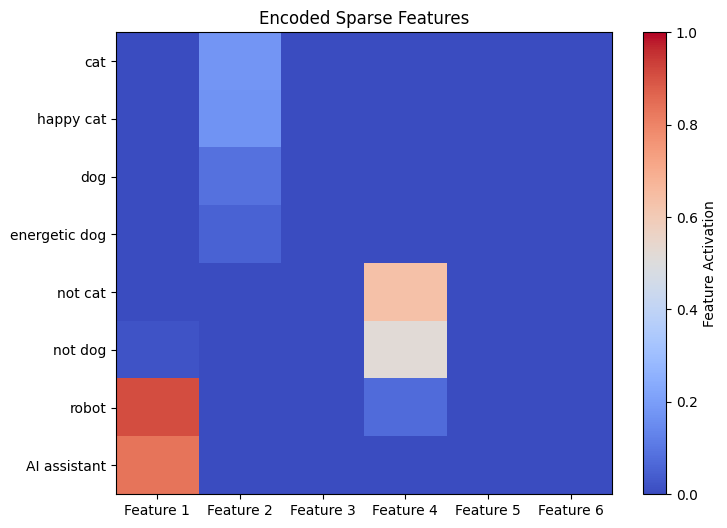

In [9]:
import torch.optim as optim
# Define the dimensions for the dummy data
cfg = SAEConfig(d_in=4, d_latent = 6, sparsity_coeff=0.07)
act_dim = 4  # Number of input features
latent_dim = 6  # Number of latent features

num_epochs = 1000
learning_rate = 0.01


# Initialize the AutoEncoder
model = SparseAutoEncoder(cfg).to(device)
# Optimizer w. betas (0.9, 0.999), no weight decay. (Anthropic april)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Move data to the same device as the model
data = data.to(device)

for epoch in range(num_epochs):
    optimizer.zero_grad()
# Forward pass
    encoded = model.encode(data)
    decoded = model.decode(encoded)

    reconstruction_loss = model.mse_loss(decoded, data) # MSE loss for reconstruction
    sparsity_loss = model.l1_loss(encoded)  # L1 loss for sparsity
    
    # Total loss
    # The SAE loss is a combination of the reconstruction loss and the sparsity loss
    loss = model.calculate_sae_loss(x=data, reconstructed=decoded, encoded=encoded)

    # Backward pass and optimization
    loss.backward()
    # Remove component of gradient parallel to weight of decoder
    model.remove_parallel_component_of_decoder_grad()  # Remove the parallel component of the gradient
    # Update weights
    optimizer.step()
    
    model.W_dec_normalized()  # Normalize the decoder's weight vectors after each update

    # Print loss every 50 epochs
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, L2 (Recon): {reconstruction_loss.item():.4f}, L1 (sparsity): {sparsity_loss.item():.4f}")

# Visualization of encoded features
plt.figure(figsize=(8, 6))
encoded.cpu()
plt.imshow(encoded.detach().numpy(), cmap='coolwarm', aspect='auto', vmin=0, vmax=1)
plt.colorbar(label="Feature Activation")
plt.xticks(ticks=np.arange(latent_dim), labels=[f"Feature {i+1}" for i in range(latent_dim)])
plt.yticks(ticks=np.arange(len(data)), labels=["cat", "happy cat", "dog",  "energetic dog", "not cat", "not dog", "robot", "AI assistant"])
plt.title("Encoded Sparse Features")
plt.show()

In [10]:

class JumpReluAutoEncoder(nn.Module):
    """
    An autoencoder with jump ReLUs.
    """

    def __init__(self, cfg, device="cpu"):
        super().__init__()
        self.cfg = cfg
        self.d_in = cfg.d_in #activation_dim
        self.d_latent = cfg.d_latent # dict_size
        self.W_enc = nn.Parameter(t.empty(self.d_in, self.d_latent, device=device))
        self.b_enc = nn.Parameter(t.zeros(self.d_latent, device=device))
        self.W_dec = nn.Parameter(
            t.nn.init.kaiming_uniform_(t.empty(self.d_latent, self.d_in, device=device))
        )
        self.b_dec = nn.Parameter(t.zeros(self.d_in, device=device))
        self.threshold = nn.Parameter(t.ones(self.d_latent, device=device) * 0.001)  # Appendix I

        self.apply_b_dec_to_input = False

        self.W_dec.data = self.W_dec / self.W_dec.norm(dim=1, keepdim=True)
        self.W_enc.data = self.W_dec.data.clone().T

    def encode(self, x, output_pre_jump=False):
        if self.apply_b_dec_to_input:
            x = x - self.b_dec
        pre_jump = x @ self.W_enc + self.b_enc

        f = nn.ReLU()(pre_jump * (pre_jump > self.threshold))

        if output_pre_jump:
            return f, pre_jump
        else:
            return f

    def decode(self, f):
        return f @ self.W_dec + self.b_dec

    def forward(self, x, output_features=False):
        """
        Forward pass of an autoencoder.
        x : activations to be autoencoded
        output_features : if True, return the encoded features (and their pre-jump version) as well as the decoded x
        """
        f = self.encode(x)
        x_hat = self.decode(f)
        if output_features:
            return x_hat, f
        else:
            return x_hat

    def scale_biases(self, scale: float):
        self.b_dec.data *= scale
        self.b_enc.data *= scale
        self.threshold.data *= scale

In [12]:
from typing import Optional, Callable

@t.no_grad()
def set_decoder_norm_to_unit_norm(
    W_dec_DF: t.nn.Parameter, activation_dim: int, d_sae: int
) -> t.Tensor:
    """There's a major footgun here: we use this with both nn.Linear and nn.Parameter decoders.
    nn.Linear stores the decoder weights in a transposed format (d_model, d_sae). So, we pass the dimensions in
    to catch this error."""

    D, F = W_dec_DF.shape

    assert D == activation_dim
    assert F == d_sae

    eps = t.finfo(W_dec_DF.dtype).eps
    norm = t.norm(W_dec_DF.data, dim=0, keepdim=True)
    W_dec_DF.data /= norm + eps
    return W_dec_DF.data

@t.no_grad()
def remove_gradient_parallel_to_decoder_directions(
    W_dec_DF: t.Tensor,
    W_dec_DF_grad: t.Tensor,
    activation_dim: int,
    d_sae: int,
) -> t.Tensor:
    """There's a major footgun here: we use this with both nn.Linear and nn.Parameter decoders.
    nn.Linear stores the decoder weights in a transposed format (d_model, d_sae). So, we pass the dimensions in
    to catch this error."""

    D, F = W_dec_DF.shape
    assert D == activation_dim
    assert F == d_sae

    normed_W_dec_DF = W_dec_DF / (t.norm(W_dec_DF, dim=0, keepdim=True) + 1e-6)

    parallel_component = einops.einsum(
        W_dec_DF_grad,
        normed_W_dec_DF,
        "d_in d_sae, d_in d_sae -> d_sae",
    )
    W_dec_DF_grad -= einops.einsum(
        parallel_component,
        normed_W_dec_DF,
        "d_sae, d_in d_sae -> d_in d_sae",
    )
    return W_dec_DF_grad

def get_lr_schedule(
    total_steps: int,
    warmup_steps: int,
    decay_start: Optional[int] = None,
    resample_steps: Optional[int] = None,
    sparsity_warmup_steps: Optional[int] = None,
) -> Callable[[int], float]:
    """
    Creates a learning rate schedule function with linear warmup followed by an optional decay phase.

    Note: resample_steps creates a repeating warmup pattern instead of the standard phases, but
    is rarely used in practice.

    Args:
        total_steps: Total number of training steps
        warmup_steps: Steps for linear warmup from 0 to 1
        decay_start: Optional step to begin linear decay to 0
        resample_steps: Optional period for repeating warmup pattern
        sparsity_warmup_steps: Used for validation with decay_start

    Returns:
        Function that computes LR scale factor for a given step
    """
    if decay_start is not None:
        assert resample_steps is None, (
            "decay_start and resample_steps are currently mutually exclusive."
        )
        assert 0 <= decay_start < total_steps, "decay_start must be >= 0 and < steps."
        assert decay_start > warmup_steps, "decay_start must be > warmup_steps."
        if sparsity_warmup_steps is not None:
            assert decay_start > sparsity_warmup_steps, (
                "decay_start must be > sparsity_warmup_steps."
            )

    assert 0 <= warmup_steps < total_steps, "warmup_steps must be >= 0 and < steps."

    if resample_steps is None:

        def lr_schedule(step: int) -> float:
            if step < warmup_steps:
                # Warm-up phase
                return step / warmup_steps

            if decay_start is not None and step >= decay_start:
                # Decay phase
                return (total_steps - step) / (total_steps - decay_start)

            # Constant phase
            return 1.0
    else:
        assert 0 < resample_steps < total_steps, "resample_steps must be > 0 and < steps."

        def lr_schedule(step: int) -> float:
            return min((step % resample_steps) / warmup_steps, 1.0)

    return lr_schedule


def get_sparsity_warmup_fn(
    total_steps: int, sparsity_warmup_steps: Optional[int] = None
) -> Callable[[int], float]:
    """
    Return a function that computes a scale factor for sparsity penalty at a given step.

    If `sparsity_warmup_steps` is None or 0, returns 1.0 for all steps.
    Otherwise, scales from 0.0 up to 1.0 across `sparsity_warmup_steps`.
    """

    if sparsity_warmup_steps is not None:
        assert 0 <= sparsity_warmup_steps < total_steps, (
            "sparsity_warmup_steps must be >= 0 and < steps."
        )

    def scale_fn(step: int) -> float:
        if not sparsity_warmup_steps:
            # If it's None or zero, we just return 1.0
            return 1.0
        else:
            # Gradually increase from 0.0 -> 1.0 as step goes from 0 -> sparsity_warmup_steps
            return min(step / sparsity_warmup_steps, 1.0)

    return scale_fn

In [13]:

class RectangleFunction(t.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return ((x > -0.5) & (x < 0.5)).float()

    @staticmethod
    def backward(ctx, grad_output):
        (x,) = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[(x <= -0.5) | (x >= 0.5)] = 0
        return grad_input


class JumpReLUFunction(t.autograd.Function):
    @staticmethod
    def forward(ctx, x, threshold, bandwidth):
        ctx.save_for_backward(x, threshold, t.tensor(bandwidth))
        return x * (x > threshold).float()

    @staticmethod
    def backward(ctx, grad_output):
        x, threshold, bandwidth_tensor = ctx.saved_tensors
        bandwidth = bandwidth_tensor.item()
        x_grad = (x > threshold).float() * grad_output
        threshold_grad = (
            -(threshold / bandwidth)
            * RectangleFunction.apply((x - threshold) / bandwidth)
            * grad_output
        )
        return x_grad, threshold_grad, None  # None for bandwidth


class StepFunction(t.autograd.Function):
    @staticmethod
    def forward(ctx, x, threshold, bandwidth):
        ctx.save_for_backward(x, threshold, t.tensor(bandwidth))
        return (x > threshold).float()

    @staticmethod
    def backward(ctx, grad_output):
        x, threshold, bandwidth_tensor = ctx.saved_tensors
        bandwidth = bandwidth_tensor.item()
        x_grad = t.zeros_like(x)
        threshold_grad = (
            -(1.0 / bandwidth) * RectangleFunction.apply((x - threshold) / bandwidth) * grad_output
        )
        return x_grad, threshold_grad, None  # None for bandwidth

In [14]:
import torch
import torch.autograd as autograd
from torch import nn
from typing import Optional
from collections import namedtuple

def loss(self, x: torch.Tensor, step: int, logging=False, **_):
        # Note: We are using threshold, not log_threshold as in this notebook:
        # https://colab.research.google.com/drive/1PlFzI_PWGTN9yCQLuBcSuPJUjgHL7GiD#scrollTo=yP828a6uIlSO
        # I had poor results when using log_threshold and it would complicate the scale_biases() function

        sparsity_scale = self.sparsity_warmup_fn(step)
        x = x.to(self.ae.W_enc.dtype)

        pre_jump = x @ self.ae.W_enc + self.ae.b_enc
        f = JumpReLUFunction.apply(pre_jump, self.ae.threshold, self.bandwidth)

        active_indices = f.sum(0) > 0
        did_fire = torch.zeros_like(self.num_tokens_since_fired, dtype=torch.bool)
        did_fire[active_indices] = True
        self.num_tokens_since_fired += x.size(0)
        self.num_tokens_since_fired[active_indices] = 0
        self.dead_features = (
            (self.num_tokens_since_fired > self.dead_feature_threshold).sum().item()
        )

        recon = self.ae.decode(f)

        recon_loss = (x - recon).pow(2).sum(dim=-1).mean()
        l0 = StepFunction.apply(f, self.ae.threshold, self.bandwidth).sum(dim=-1).mean()

        sparsity_loss = (
            self.sparsity_coefficient * ((l0 / self.target_l0) - 1).pow(2) * sparsity_scale
        )
        loss = recon_loss + sparsity_loss

        if not logging:
            return loss
        else:
            return namedtuple("LossLog", ["x", "recon", "f", "losses"])(
                x,
                recon,
                f,
                {
                    "l2_loss": recon_loss.item(),
                    "loss": loss.item(),
                },
            )

def update(self, step, x):
    x = x.to(self.device)
    loss = self.loss(x, step=step)
    loss.backward()

    # We must transpose because we are using nn.Parameter, not nn.Linear
    self.ae.W_dec.grad = remove_gradient_parallel_to_decoder_directions(
        self.ae.W_dec.T, self.ae.W_dec.grad.T, self.ae.activation_dim, self.ae.dict_size
    ).T
    torch.nn.utils.clip_grad_norm_(self.ae.parameters(), 1.0)

    self.optimizer.step()
    self.scheduler.step()
    self.optimizer.zero_grad()

    # We must transpose because we are using nn.Parameter, not nn.Linear
    self.ae.W_dec.data = set_decoder_norm_to_unit_norm(
        self.ae.W_dec.T, self.ae.activation_dim, self.ae.dict_size
    ).T

    return loss.item()

In [26]:
import itertools
NUM_STEPS = 3
BATCH_SIZE = 1024
ACTIVATIONS_SIZE = 16
SAE_WIDTH = 128
THRESHOLD_INIT = 0.001
# We use a higher bandwidth than in the paper to ensure a non-zero gradient
# to the threshold at every step (since we'll only be taking three steps)
BANDWIDTH = 0.1
FIX_DECODER_NORMS = True
LEARNING_RATE = 0.001  # Note this is not the learning rate in the paper
ADAM_B1 = 0.0
DATA_SEED = 9328302
PARAMS_SEED = 24396



In [16]:
rng = np.random.default_rng(DATA_SEED)
dataset = rng.normal(
    size=(NUM_STEPS, BATCH_SIZE, ACTIVATIONS_SIZE)
) / np.sqrt(ACTIVATIONS_SIZE)

# We choose an initialization that is useful for testing. Specifically
# this means we initialize the biases and threshold to non-zero values
# and that we don't set the encoder weights to the transpose of the decoder
# (since they won't in general during training).
rng = np.random.default_rng(PARAMS_SEED)
W_dec = (rng.uniform(size=(SAE_WIDTH, ACTIVATIONS_SIZE)) - 0.5)
W_dec /= np.linalg.norm(W_dec, axis=-1, keepdims=True)
W_enc = (rng.uniform(size=(ACTIVATIONS_SIZE, SAE_WIDTH)) - 0.5)
b_enc = (rng.uniform(size=(SAE_WIDTH,)) - 0.5) * 0.1
b_dec = (rng.uniform(size=(ACTIVATIONS_SIZE,)) - 0.5) * 0.1
threshold = 0.15 * (rng.uniform(size=(SAE_WIDTH,))) * 0.1

In [ ]:
def rectangle_pt(x):
    return ((x > -0.5) & (x < 0.5)).to(x)


class Step(torch.autograd.Function):
    @staticmethod
    def forward(x, threshold):
        return (x > threshold).to(x)

    @staticmethod
    def setup_context(ctx, inputs, output):
        x, threshold = inputs
        del output
        ctx.save_for_backward(x, threshold)

    @staticmethod
    def backward(ctx, grad_output):
        x, threshold = ctx.saved_tensors
        x_grad = 0.0 * grad_output  # We don't apply STE to x input
        threshold_grad = torch.sum(
            -(1.0 / BANDWIDTH)
            * rectangle_pt((x - threshold) / BANDWIDTH)
            * grad_output,
            dim=0,
        )
        return x_grad, threshold_grad


class JumpReLU(torch.autograd.Function):
    @staticmethod
    def forward(x, threshold):
        return x * (x > threshold).to(x)

    @staticmethod
    def setup_context(ctx, inputs, output):
        x, threshold = inputs
        del output
        ctx.save_for_backward(x, threshold)

    @staticmethod
    def backward(ctx, grad_output):
        x, threshold = ctx.saved_tensors
        x_grad = (x > threshold) * grad_output  # We don't apply STE to x input
        threshold_grad = torch.sum(
            -(threshold / BANDWIDTH)
            * rectangle_pt((x - threshold) / BANDWIDTH)
            * grad_output,
            dim=0,
        )
        return x_grad, threshold_grad


class SAE(nn.Module):
    def __init__(self, sae_width, activations_size, use_pre_enc_bias):
        super().__init__()
        self.use_pre_enc_bias = use_pre_enc_bias
        self.W_enc = nn.Parameter(torch.tensor(W_enc))
        self.b_enc = nn.Parameter(torch.tensor(b_enc))
        self.W_dec = nn.Parameter(torch.tensor(W_dec))
        self.b_dec = nn.Parameter(torch.tensor(b_dec))
        self.log_threshold = nn.Parameter(
            torch.tensor(np.log(threshold))
        )

    def __call__(self, x):
        if self.use_pre_enc_bias:
            x = x - self.b_dec

        pre_activations = x @ self.W_enc + self.b_enc
        threshold = torch.exp(self.log_threshold)
        feature_magnitudes = JumpReLU.apply(pre_activations, threshold)
        x_reconstructed = feature_magnitudes @ self.W_dec + self.b_dec
        return x_reconstructed, pre_activations


def loss_fn_pt(sae, x, sparsity_coefficient, use_pre_enc_bias):
    x_reconstructed, pre_activations = sae(x)

    # Compute per-example reconstruction loss
    reconstruction_error = x - x_reconstructed
    reconstruction_loss = torch.sum(reconstruction_error**2, dim=-1)

    # Compute per-example sparsity loss
    threshold = torch.exp(sae.log_threshold)
    l0 = torch.sum(Step.apply(pre_activations, threshold), dim=-1)
    sparsity_loss = sparsity_coefficient * l0

    # Return the batch-wise mean total loss
    return torch.mean(reconstruction_loss + sparsity_loss, dim=0)

In [ ]:
def remove_parallel_component_pt(x, v):
    """Returns x with component parallel to v projected away (in PyTorch)."""
    v_normalised = v / (torch.norm(v, dim=-1, keepdim=True) + 1e-6)
    parallel_component = torch.einsum("...d,...d->...", x, v_normalised)
    return x - parallel_component[..., None] * v_normalised

def train_pt(
    dataset_iterator,
    sparsity_coefficient,
    use_pre_enc_bias,
    fix_decoder_norms,
):
    sae = SAE(SAE_WIDTH, ACTIVATIONS_SIZE, use_pre_enc_bias)
    optimizer = torch.optim.Adam(
        sae.parameters(), lr=LEARNING_RATE, betas=(ADAM_B1, 0.999)
    )
    for batch in dataset_iterator:
        optimizer.zero_grad()
        loss_pt = loss_fn_pt(
            sae, torch.tensor(batch), sparsity_coefficient, use_pre_enc_bias
        )
        loss_pt.backward()
        print(loss_pt.item())
        if fix_decoder_norms:
            sae.W_dec.grad = remove_parallel_component_pt(
                sae.W_dec.grad, sae.W_dec.data
            )
        optimizer.step()
        if fix_decoder_norms:
            sae.W_dec.data = sae.W_dec.data / torch.norm(
                sae.W_dec.data, dim=-1, keepdim=True
            )
    return sae

In [25]:
dataset.shape

(3, 1024, 16)

In [28]:
sae_pt_trained = train_pt(
        iter(dataset),
        sparsity_coefficient=0.1,
        use_pre_enc_bias=True,
        fix_decoder_norms=True,
    )

12.968567997696478
12.820387318943203
12.595672022608486


In [ ]:
import torch.optim as optim
# Define the dimensions for the dummy data
cfg = SAEConfig(d_in=4, d_latent = 6, sparsity_coeff=0.07)
act_dim = 4  # Number of input features
latent_dim = 6  # Number of latent features

num_epochs = 1000
learning_rate = 0.01


# Initialize the AutoEncoder
model = SparseAutoEncoder(cfg).to(device)
# Optimizer w. betas (0.9, 0.999), no weight decay. (Anthropic april)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Move data to the same device as the model
data = data.to(device)

for epoch in range(num_epochs):
    optimizer.zero_grad()
# Forward pass
    encoded = model.encode(data)
    decoded = model.decode(encoded)

    reconstruction_loss = model.mse_loss(decoded, data) # MSE loss for reconstruction
    sparsity_loss = model.l1_loss(encoded)  # L1 loss for sparsity
    
    # Total loss
    # The SAE loss is a combination of the reconstruction loss and the sparsity loss
    loss = model.calculate_sae_loss(x=data, reconstructed=decoded, encoded=encoded)

    # Backward pass and optimization
    loss.backward()
    # Remove component of gradient parallel to weight of decoder
    model.remove_parallel_component_of_decoder_grad()  # Remove the parallel component of the gradient
    # Update weights
    optimizer.step()
    
    model.W_dec_normalized()  # Normalize the decoder's weight vectors after each update

    # Print loss every 50 epochs
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, L2 (Recon): {reconstruction_loss.item():.4f}, L1 (sparsity): {sparsity_loss.item():.4f}")

# Visualization of encoded features
plt.figure(figsize=(8, 6))
encoded.cpu()
plt.imshow(encoded.detach().numpy(), cmap='coolwarm', aspect='auto', vmin=0, vmax=1)
plt.colorbar(label="Feature Activation")
plt.xticks(ticks=np.arange(latent_dim), labels=[f"Feature {i+1}" for i in range(latent_dim)])
plt.yticks(ticks=np.arange(len(data)), labels=["cat", "happy cat", "dog",  "energetic dog", "not cat", "not dog", "robot", "AI assistant"])
plt.title("Encoded Sparse Features")
plt.show()

Sae()